# Antartica Asset Management Interview Question 2


Steps: 

1. Check for any non-numeric values and missing data 

2. Check for impossible values visually on excel by looking at min and max values: 
- found 3 outliers in 'Factor - Value vs Growth' that will be replaced with median.

3. I examined the histogram and QQ plot of the data to visually assess the distribution of each variable. It appears that some variables may not follow a perfect normal distribution. To further investigate, I performed the Shapiro-Wilk test to determine if the variables are normally distributed.

4. In order to address the non-normality, I standardized the variables using `StandardScaler` to make them comparable.

5. I created interaction terms between certain factors to explore if the relationship between the returns and these factors depends on the level of another factor.

6. To check for multicollinearity, I calculated the Variance Inflation Factor (VIF) for each variable. Fortunately, I did not find any significant multicollinearity issues.

7. I fitted an initial Ordinary Least Squares (OLS) regression model to the data to explore the relationship between the returns and the factors.

8. Based on the initial model summary, I identified insignificant factors and decided to remove them from the model to improve its performance.

9. I then fitted a new OLS model with the remaining significant factors to refine the analysis.

10. To ensure the validity of the regression model, I conducted several diagnostic checks. These included examining the linearity between the observed and predicted values, verifying that the mean of the residuals is close to zero, assessing the homoscedasticity (equal variance of error terms), checking the normality of the residuals, and confirming the absence of multicollinearity using VIF.

11. I also plotted the residuals against different factors to identify any patterns or deviations that may need further investigation.

12. Finally, I used Cook's Distance to identify any outliers that may have a significant influence on the regression analysis.


In [1]:
# Imports required for code
import pandas as pd
from scipy.stats import shapiro, normaltest, anderson
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso
import statsmodels.api as sm
from scipy.stats import shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

In [2]:
# Get data from file
data = pd.read_excel("data.xlsx")

# Step 1. Check for any non-numeric values and missing data 
non_numeric_counts = data.applymap(lambda x: not isinstance(x, (int, float))).sum()
print(non_numeric_counts)
missing_counts = data.isnull().sum()
print(missing_counts)
print(data.dtypes)

perf_date                           195
Hedge Fund                            0
Factor - Low Risk                     0
Factor - Value vs Growth              0
Factor - Fixed Income Carry           0
Factor - Local Equity                 0
Factor - Trend Following              0
Factor - Commodities                  0
Factor - Equity                       0
Factor - Foreign Exchange Carry       0
Factor - Small Cap                    0
Factor - Emerging Markets             0
Factor - Foreign Currency             0
Factor - Local Inflation              0
Factor - Equity Short Volatility      0
Factor - Credit                       0
Factor - Interest Rates               0
Factor - Crowding                     0
Factor - Momentum                     0
Factor - Quality                      0
dtype: int64
perf_date                           0
Hedge Fund                          0
Factor - Low Risk                   0
Factor - Value vs Growth            0
Factor - Fixed Income Carry        

In [3]:
'''
Check for impossible values visually on excel by looking at min and max values: 
- found 3 outliers in 'Factor - Value vs Growth' that will be replaced with median.
'''
# Calculate the median of the 'Factor - Value vs Growth' column excluding the outlier values
median_value = np.median(data.loc[(data['Factor - Value vs Growth'] > -1) & (data['Factor - Value vs Growth'] < 1), 'Factor - Value vs Growth'])

# Replace the outlier values with the median
data.loc[(data['Factor - Value vs Growth'] <= -1) | (data['Factor - Value vs Growth'] >= 1), 'Factor - Value vs Growth'] = median_value

# Verify the updated values
print(data['Factor - Value vs Growth'])

# Checking for any missing data
print(data.isna().sum())

0     -0.012632
1      0.012010
2     -0.001646
3      0.002147
4      0.019188
         ...   
190    0.005199
191    0.044041
192    0.126823
193    0.011823
194    0.011146
Name: Factor - Value vs Growth, Length: 195, dtype: float64
perf_date                           0
Hedge Fund                          0
Factor - Low Risk                   0
Factor - Value vs Growth            0
Factor - Fixed Income Carry         0
Factor - Local Equity               0
Factor - Trend Following            0
Factor - Commodities                0
Factor - Equity                     0
Factor - Foreign Exchange Carry     0
Factor - Small Cap                  0
Factor - Emerging Markets           0
Factor - Foreign Currency           0
Factor - Local Inflation            0
Factor - Equity Short Volatility    0
Factor - Credit                     0
Factor - Interest Rates             0
Factor - Crowding                   0
Factor - Momentum                   0
Factor - Quality                    0
dtyp

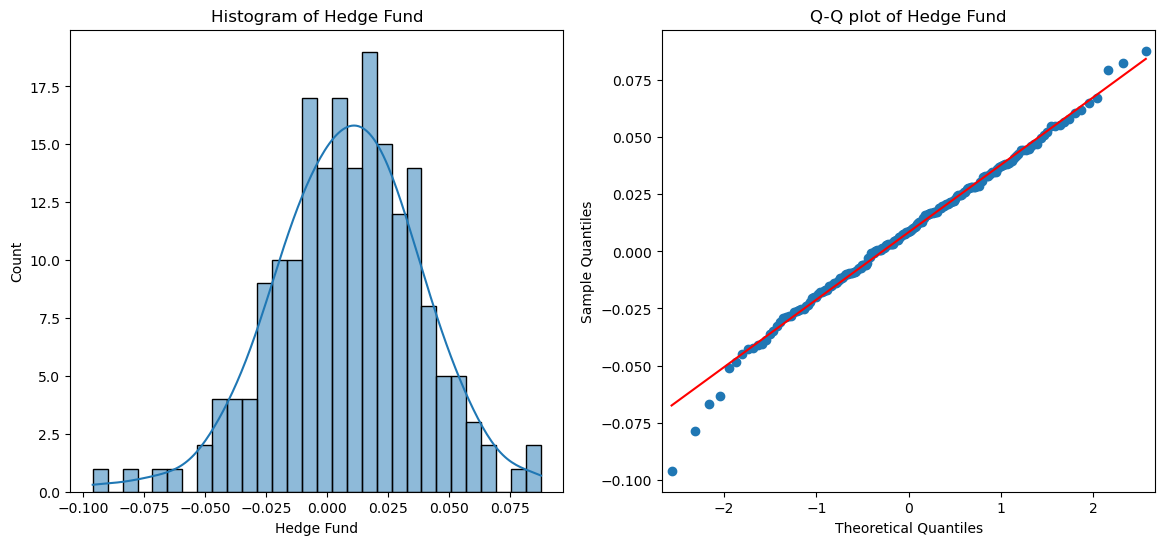

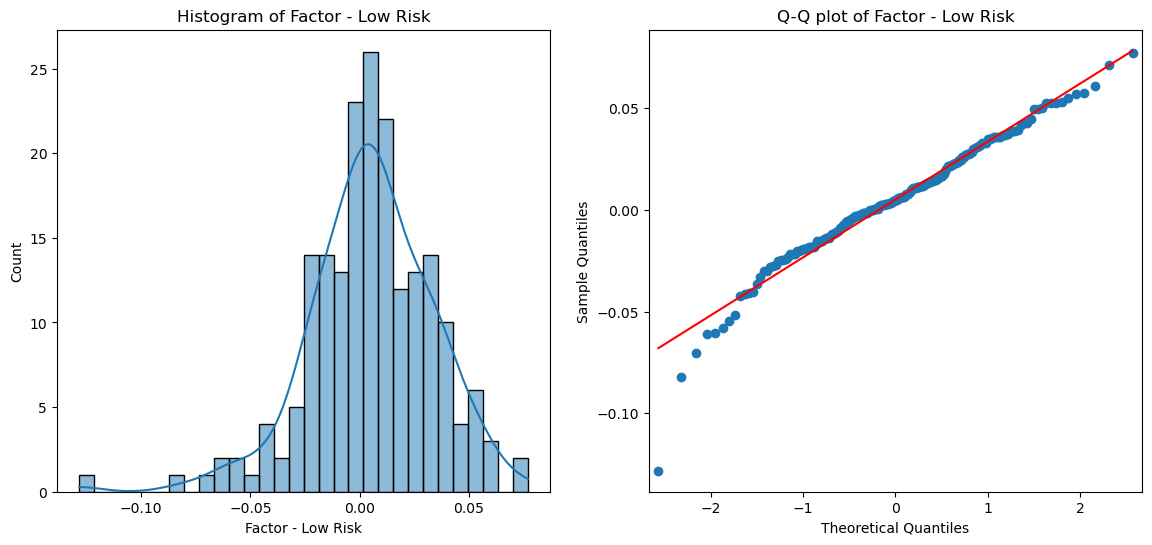

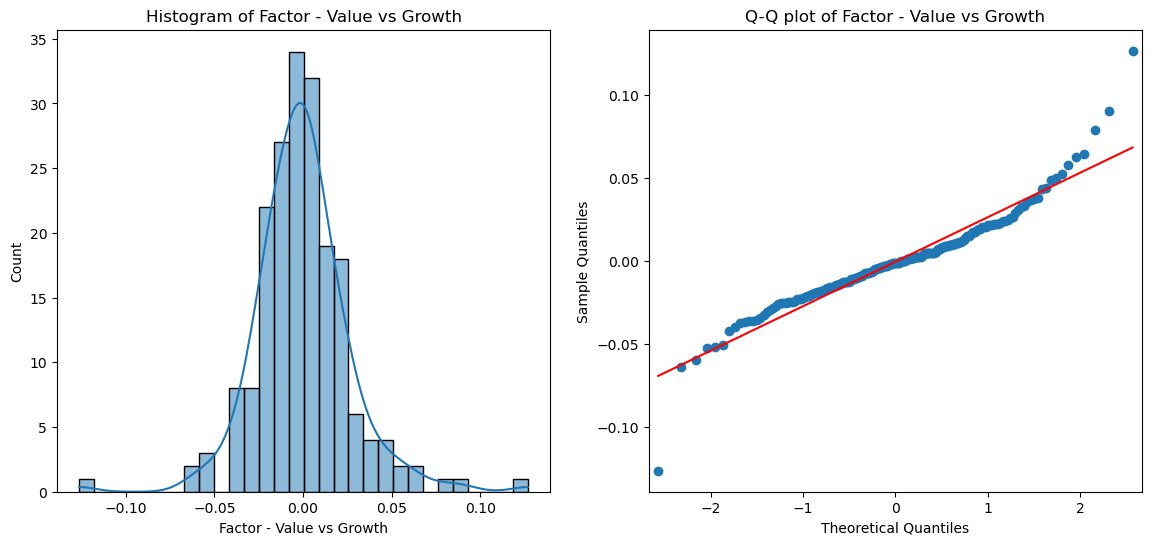

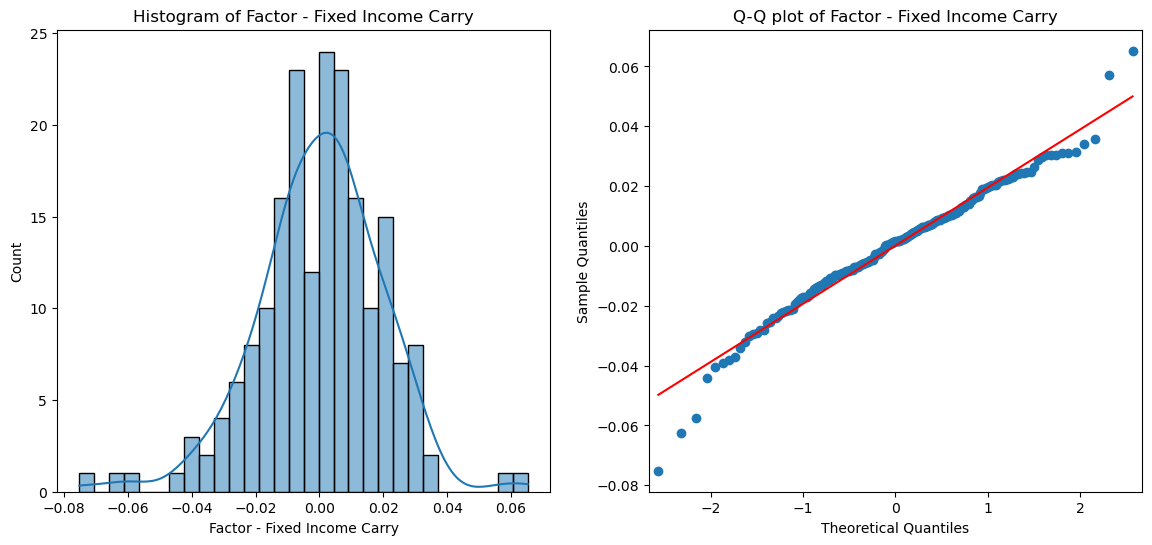

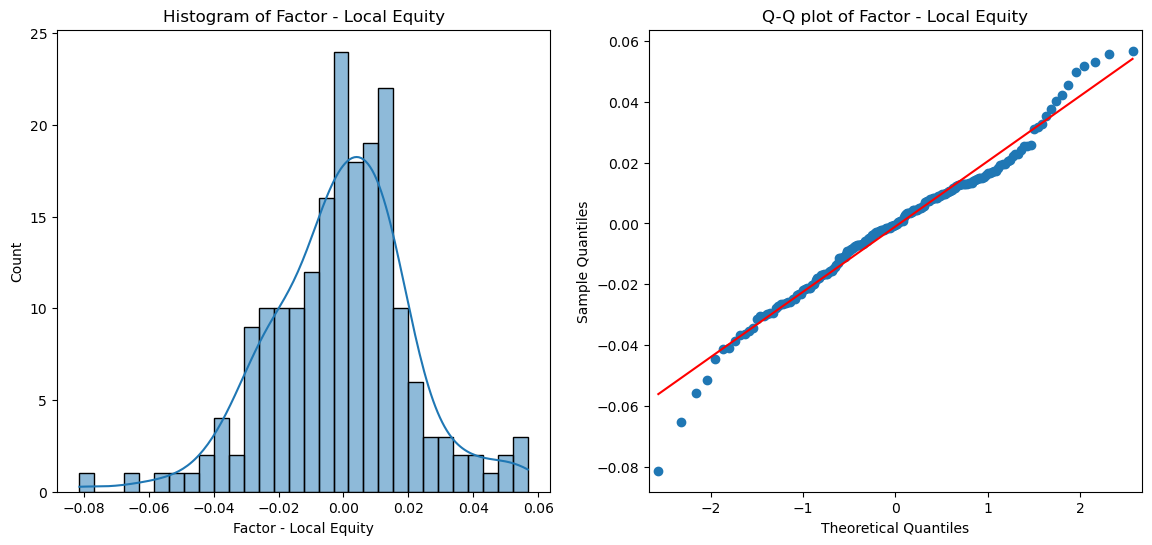

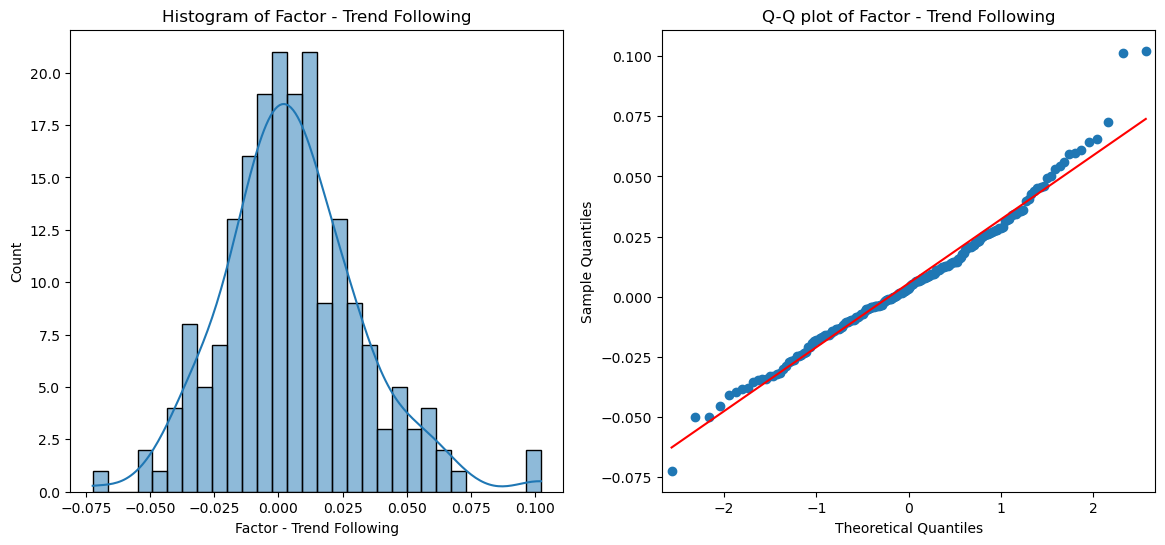

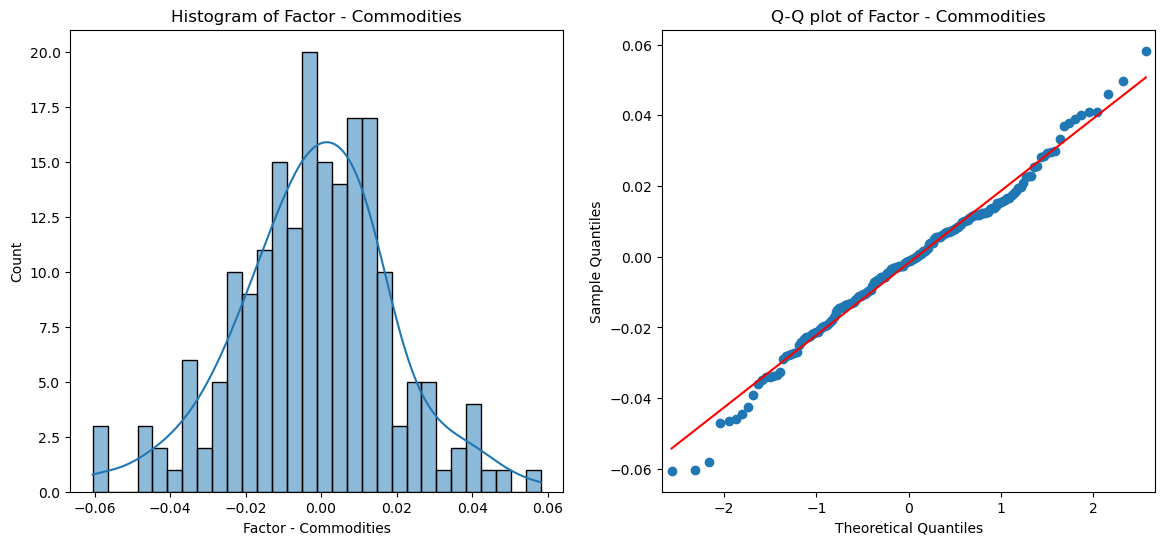

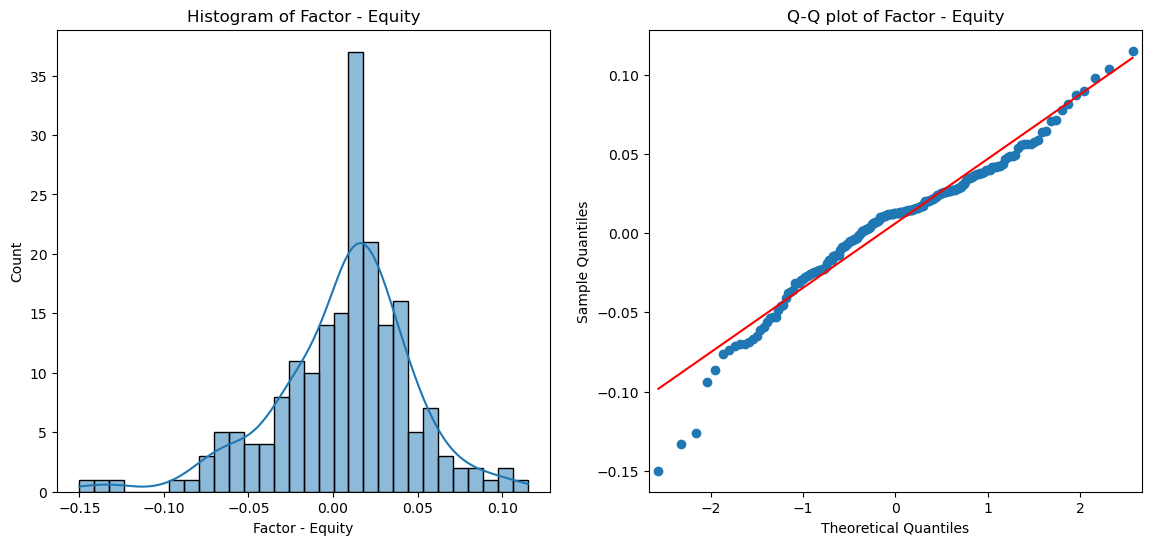

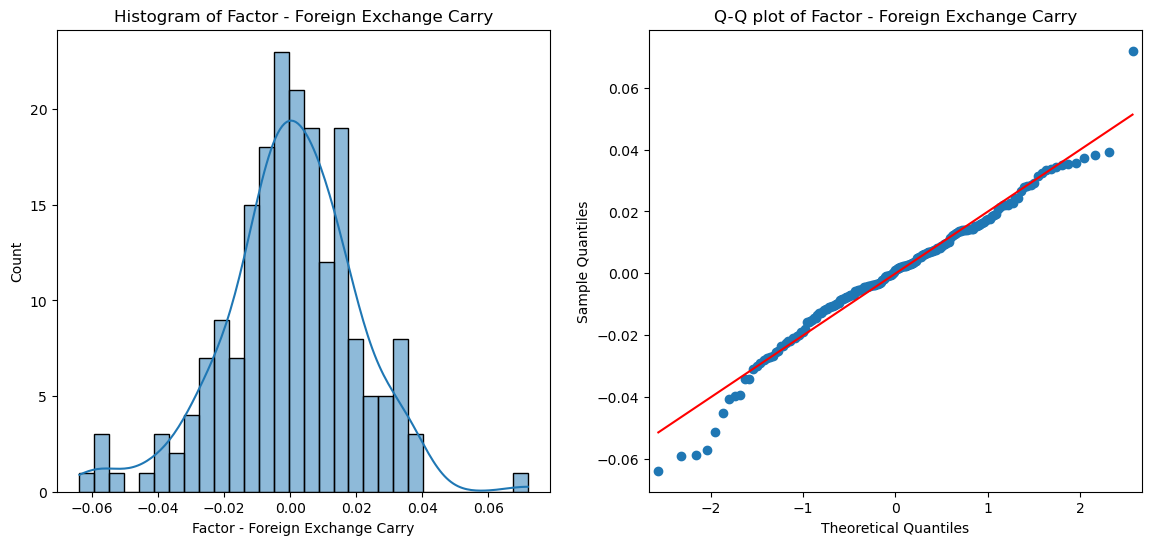

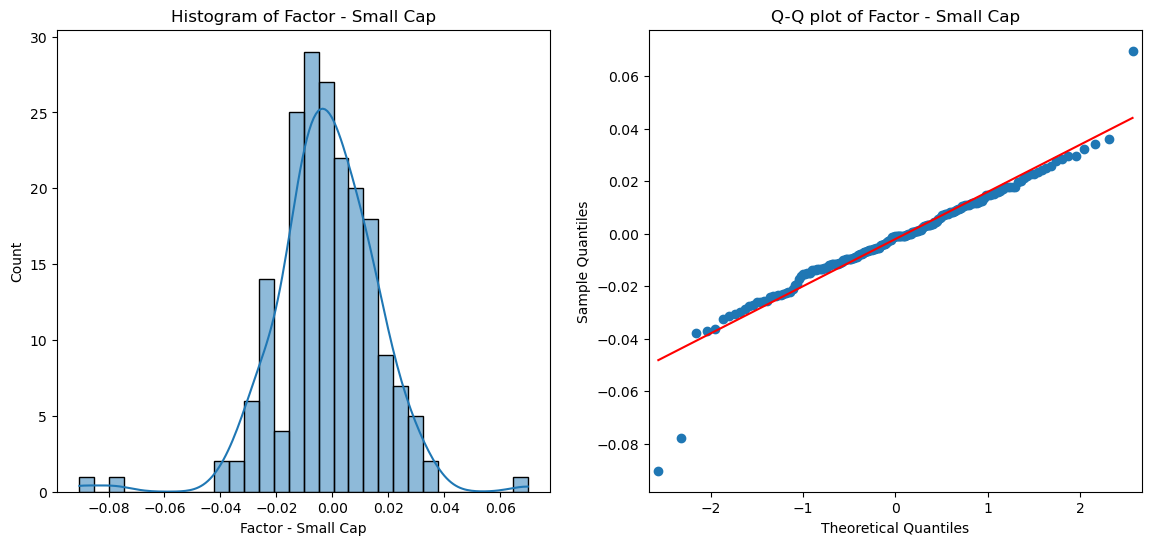

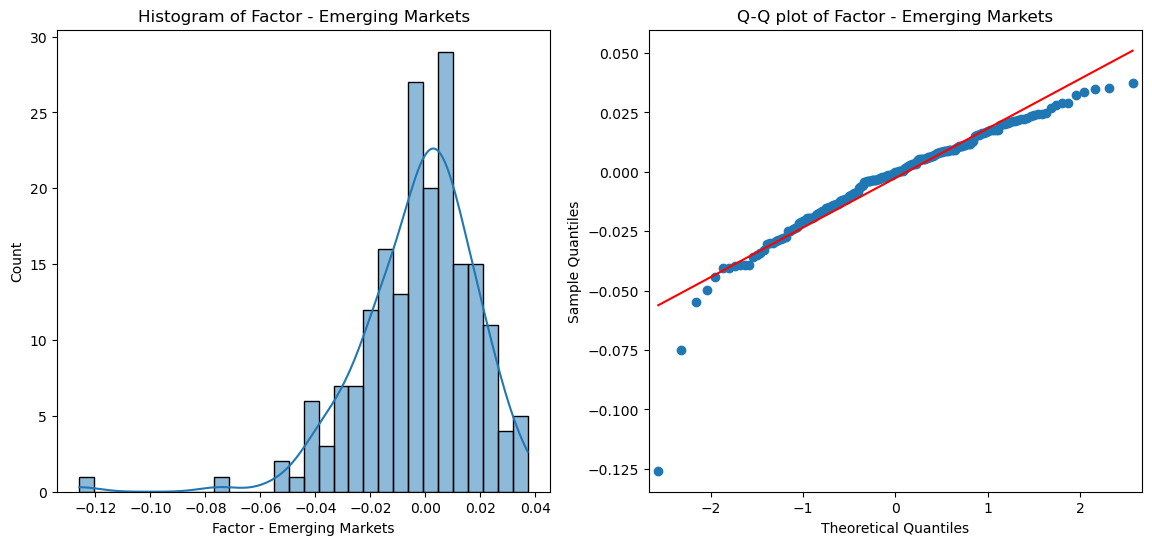

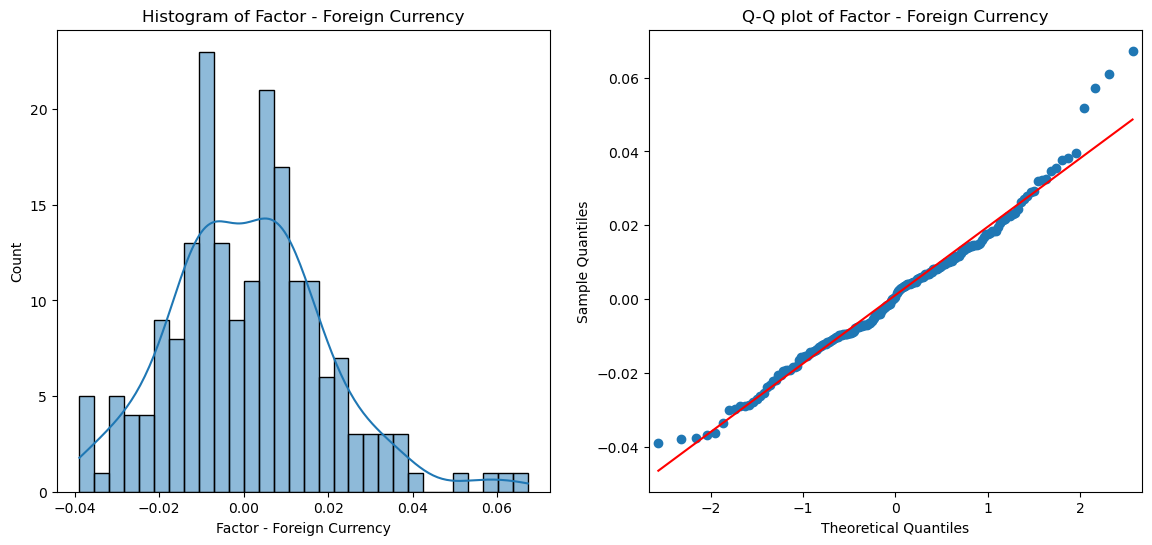

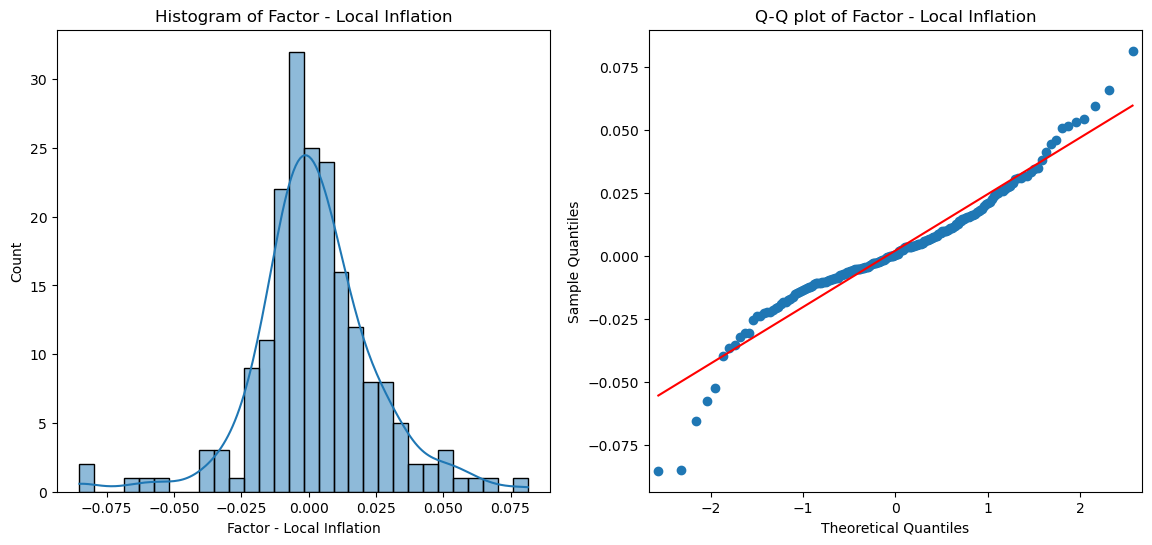

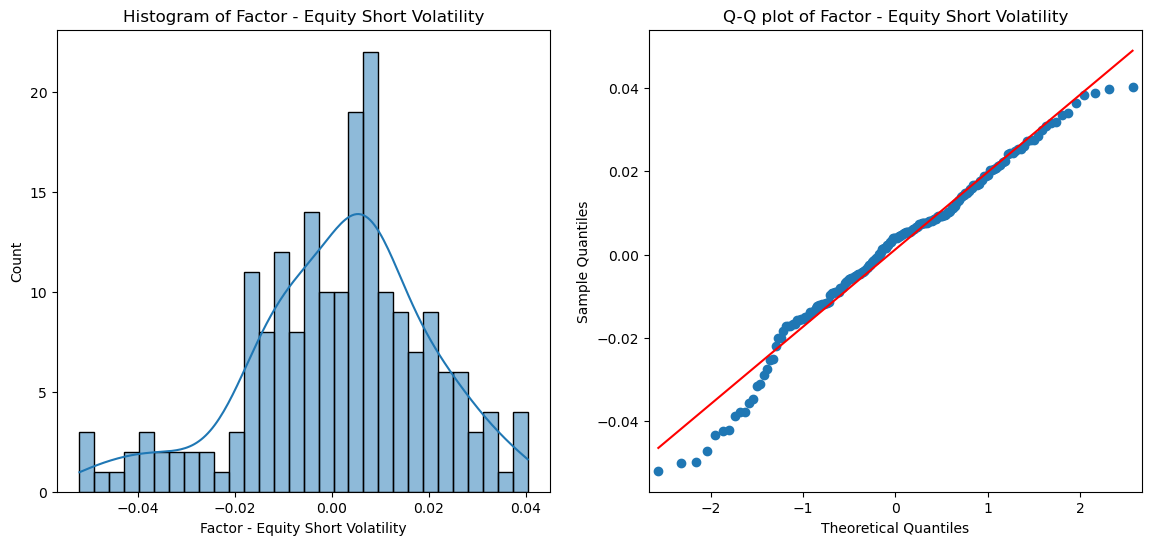

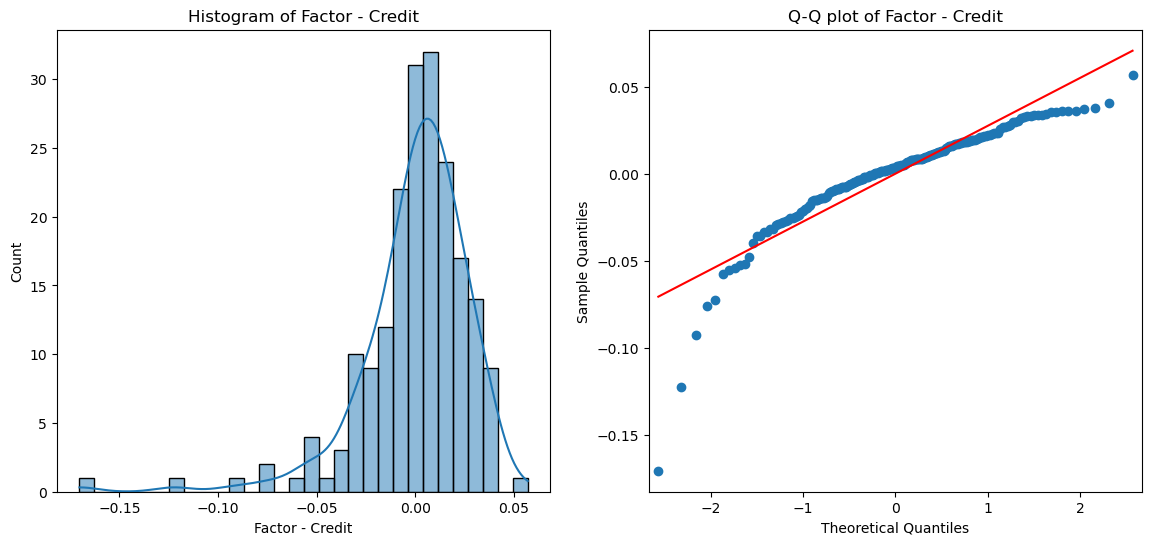

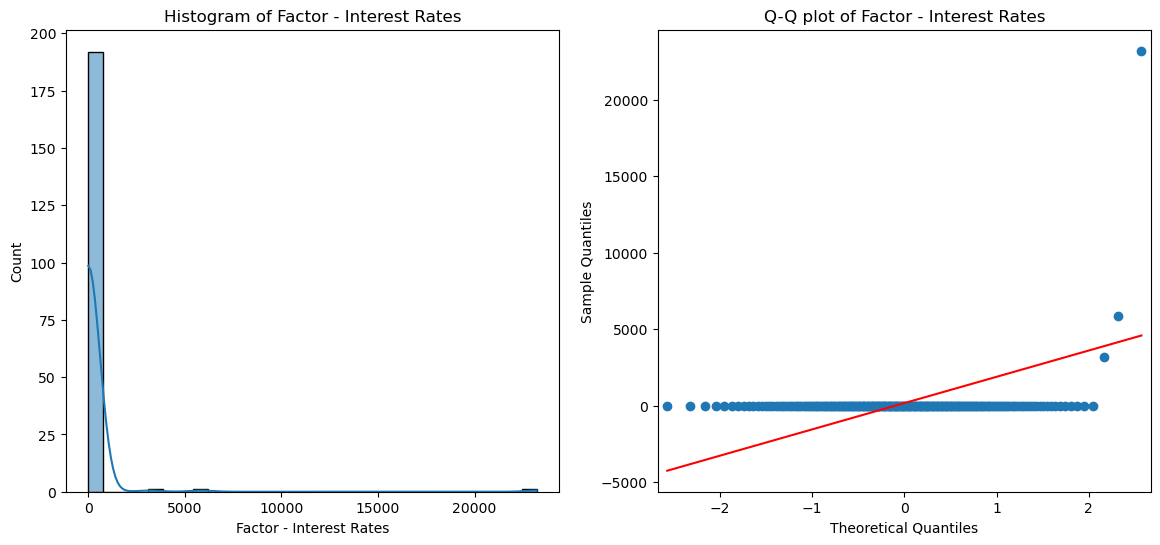

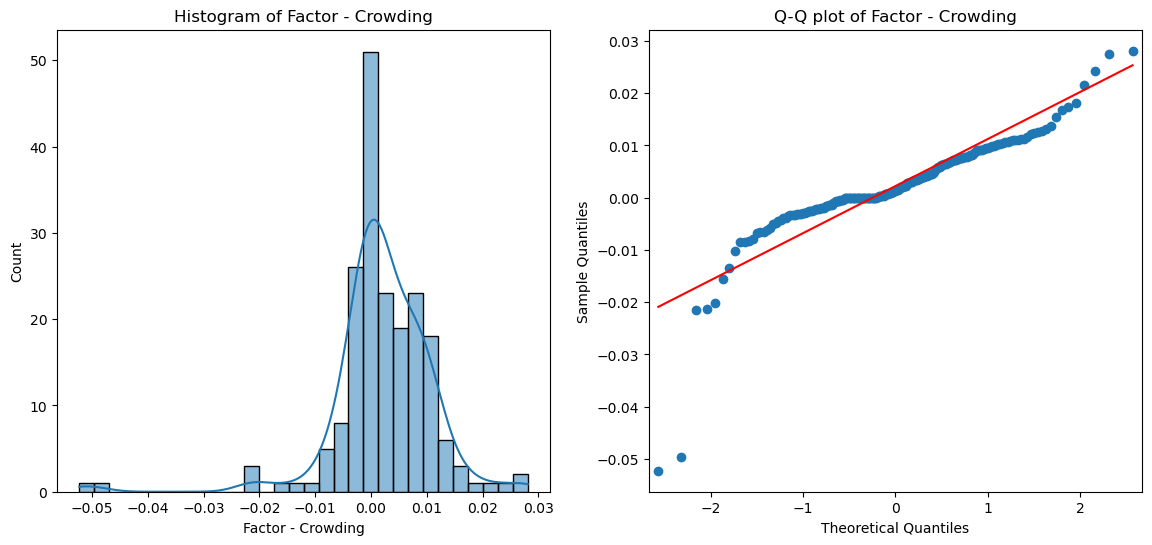

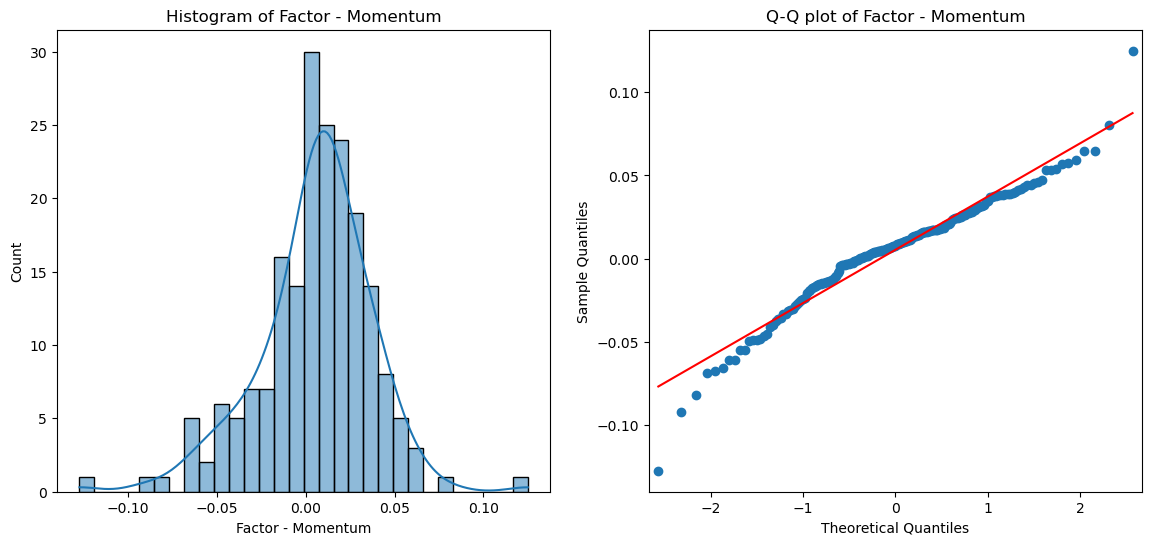

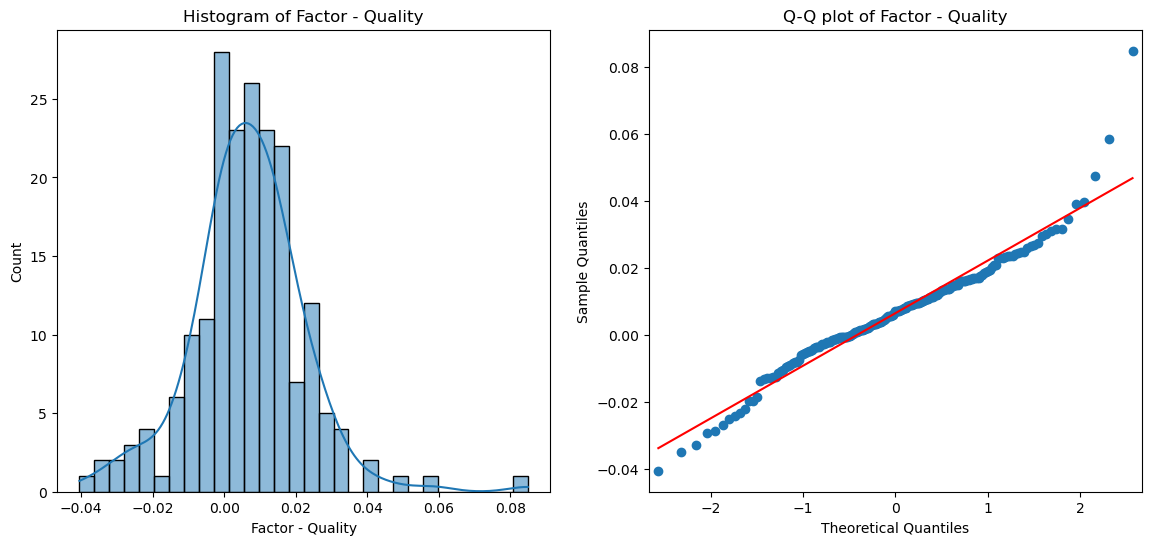

Shapiro-Wilk Test for Hedge Fund:
Statistic = 0.9932431578636169, p-value = 0.5128647089004517
Hedge Fund looks Gaussian (fail to reject H0)

Shapiro-Wilk Test for Factor - Low Risk:
Statistic = 0.969946563243866, p-value = 0.00034040797618217766
Factor - Low Risk does not look Gaussian (reject H0)

Shapiro-Wilk Test for Factor - Value vs Growth:
Statistic = 0.9317362308502197, p-value = 6.375250194423643e-08
Factor - Value vs Growth does not look Gaussian (reject H0)

Shapiro-Wilk Test for Factor - Fixed Income Carry:
Statistic = 0.9782496094703674, p-value = 0.003975125961005688
Factor - Fixed Income Carry does not look Gaussian (reject H0)

Shapiro-Wilk Test for Factor - Local Equity:
Statistic = 0.9814288020133972, p-value = 0.010980021208524704
Factor - Local Equity does not look Gaussian (reject H0)

Shapiro-Wilk Test for Factor - Trend Following:
Statistic = 0.9799758791923523, p-value = 0.006866877432912588
Factor - Trend Following does not look Gaussian (reject H0)

Shapiro-Wi

In [4]:
'''
3. I examined the histogram and QQ plot of the data to visually assess the distribution of each variable. 
It appears that some variables may not follow a perfect normal distribution. 
To further investigate, I performed the Shapiro-Wilk test to determine if the variables are normally 
distributed.
'''

features = data.columns[1:]

# 1. Visual inspection: histogram and Q-Q plot
for feature in features:
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    sns.histplot(data[feature], kde=True, bins=30)
    plt.title(f"Histogram of {feature}")
    
    plt.subplot(1, 2, 2)
    qqplot(data[feature], line='s', ax=plt.gca())
    plt.title(f"Q-Q plot of {feature}")
    
    plt.show()

# 2. Shapiro-Wilk Test
for feature in features:
    stat, p = shapiro(data[feature])
    print(f"Shapiro-Wilk Test for {feature}:")
    print(f"Statistic = {stat}, p-value = {p}")
    if p > 0.05:
        print(f"{feature} looks Gaussian (fail to reject H0)")
    else:
        print(f"{feature} does not look Gaussian (reject H0)")
    print()

# 3. Skewness and Kurtosis
for feature in features:
    skewness = data[feature].skew()
    kurtosis = data[feature].kurtosis()
    print(f"For {feature}: skewness = {skewness}, kurtosis = {kurtosis}")
    print()


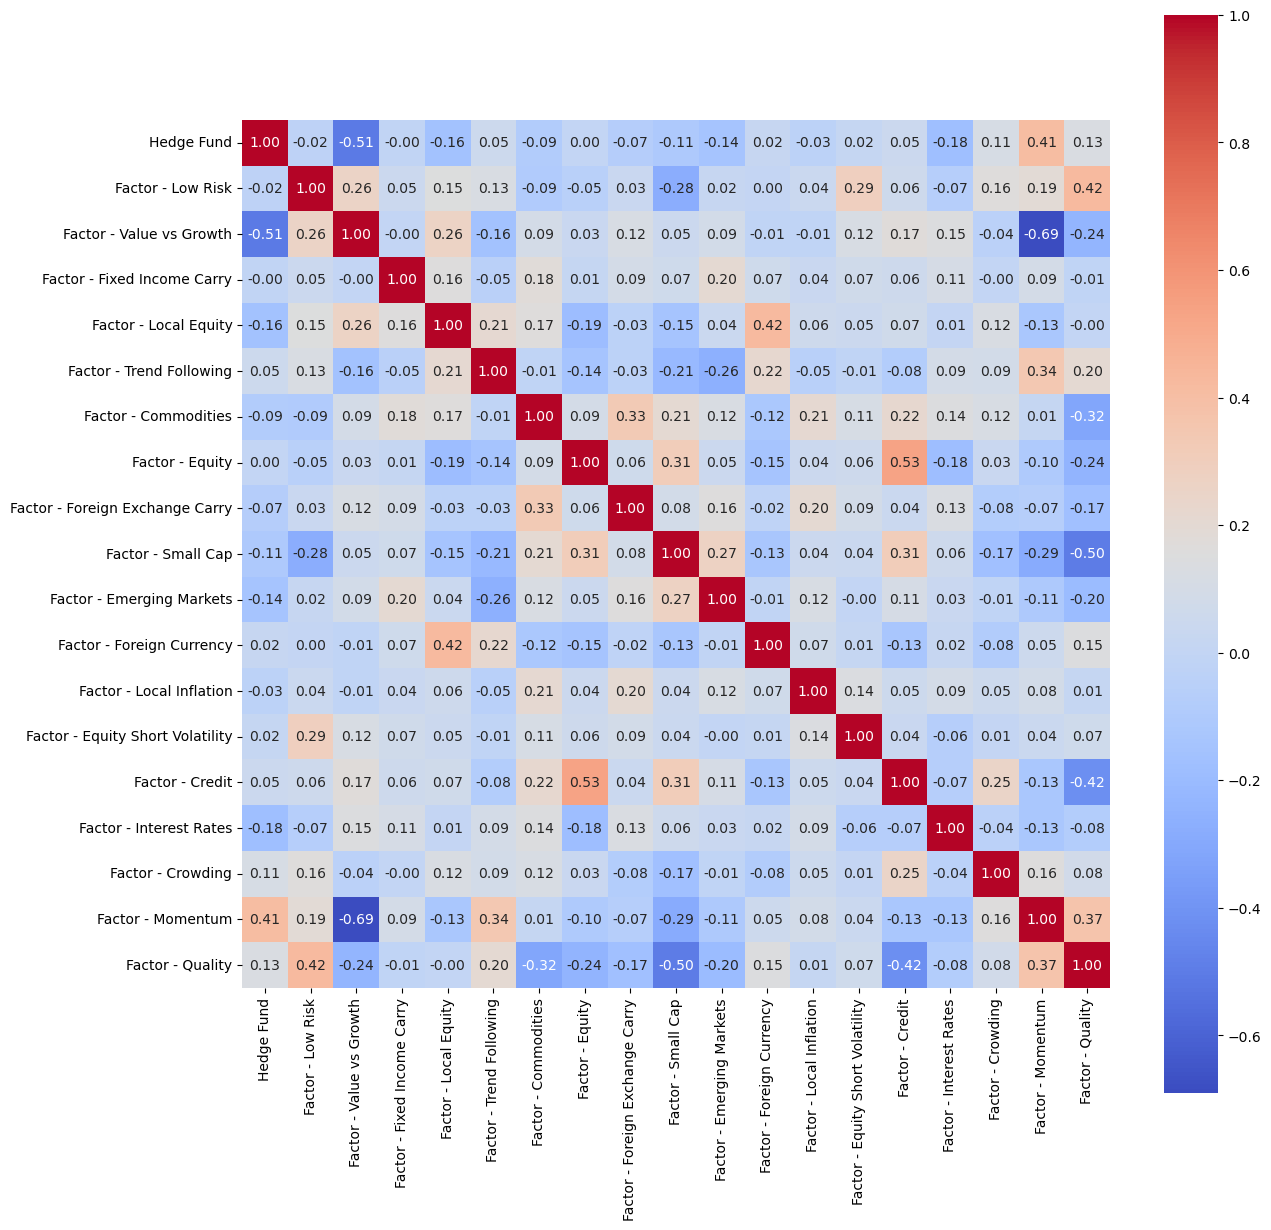

In [5]:
# Calculate correlations
corr = data.drop('perf_date', axis=1).corr()

# Heatmap
plt.figure(figsize=(14, 14))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.show()

In [6]:
'''
4. In order to address the non-normality, I standardized the variables using `StandardScaler` to make them comparable.

5. I created interaction terms between certain factors to explore if the relationship between the returns and these factors depends on the level of another factor.

6. To check for multicollinearity, I calculated the Variance Inflation Factor (VIF) for each variable. Fortunately, I did not find any significant multicollinearity issues.
'''
# Name the data now as df
df = data

# Removing the 'perf_date' column since we're not using it for the regression analysis
df.drop(columns='perf_date', inplace=True)

# Convert columns to appropriate data types
df = df.convert_dtypes()

# Define dependent variable
Y = df['Hedge Fund']

# Define independent variables
numeric_cols = df.columns[1:]

# Normalize only non-normal data with StandardScaler because we have very small values in some factors
non_normal_columns = ['Factor - Low Risk', 'Factor - Value vs Growth', 'Factor - Fixed Income Carry', 'Factor - Local Equity',
                      'Factor - Trend Following', 'Factor - Equity', 'Factor - Foreign Exchange Carry', 'Factor - Small Cap',
                      'Factor - Emerging Markets', 'Factor - Foreign Currency', 'Factor - Local Inflation',
                      'Factor - Equity Short Volatility', 'Factor - Credit', 'Factor - Interest Rates', 'Factor - Crowding',
                      'Factor - Momentum', 'Factor - Quality']

scaler = StandardScaler()
df[non_normal_columns] = scaler.fit_transform(df[non_normal_columns])

# Interaction Terms for common significant interactions
df['interaction_term2'] = df['Factor - Small Cap'] * df['Factor - Momentum']
df['interaction_term3'] = df['Factor - Equity'] * df['Factor - Momentum']

"""
Based on the objectives and the type of the fund (equity long/short hedge fund), 
some factors that could be considered as theoretically and practically important:

Factor - Equity: This factor is obviously important for an equity long/short hedge 
fund because the fund's returns are heavily influenced by equity market movements.

Factor - Small Cap: This factor could be relevant depending on the hedge fund's focus. 
If the fund invests in small-cap stocks, this factor could play a significant role.

Factor - Momentum: Momentum is a commonly used factor in equity strategies. 
A hedge fund could potentially take advantage of momentum in the market.
"""
# Also tried the following terms but none were significant or resulted in a high vif score for certain factors
#df['interaction_term1'] = df['Factor - Small Cap'] * df['Factor - Equity']
#df['interaction_term4'] = df['Factor - Local Equity'] * df['Factor - Trend Following']
#df['interaction_term5'] = df['Factor - Foreign Exchange Carry'] * df['Factor - Interest Rates']
#df['interaction_term6'] = df['Factor - Equity'] * df['Factor - Quality']
#df['interaction_term7'] = df['Factor - Credit'] * df['Factor - Crowding']

X = df[numeric_cols.tolist() + ['interaction_term2', 'interaction_term3']]

# Add Constant
X = sm.add_constant(X)

# Check for multicollinearity
vif = pd.DataFrame()
X = X.astype('float64')
Y = Y.astype('float64')
vif['variables'] = X.columns

vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif)

                           variables       VIF
0                              const  1.060095
1                  Factor - Low Risk  2.303772
2           Factor - Value vs Growth  3.345756
3        Factor - Fixed Income Carry  1.178077
4              Factor - Local Equity  1.837458
5           Factor - Trend Following  1.419214
6               Factor - Commodities  1.549357
7                    Factor - Equity  1.754218
8    Factor - Foreign Exchange Carry  1.262996
9                 Factor - Small Cap  1.762026
10         Factor - Emerging Markets  1.286383
11         Factor - Foreign Currency  1.417100
12          Factor - Local Inflation  1.170457
13  Factor - Equity Short Volatility  1.183726
14                   Factor - Credit  2.111186
15           Factor - Interest Rates  1.293619
16                 Factor - Crowding  1.298081
17                 Factor - Momentum  3.471185
18                  Factor - Quality  2.373448
19                 interaction_term2  1.827194
20           

In [7]:
'''
7. I fitted an initial Ordinary Least Squares (OLS) regression model to the data to explore the relationship between the returns and the factors.
'''

# Fit Model
model = sm.OLS(Y, X).fit()

# Print Model Summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             Hedge Fund   R-squared:                       0.396
Model:                            OLS   Adj. R-squared:                  0.327
Method:                 Least Squares   F-statistic:                     5.709
Date:                Tue, 23 May 2023   Prob (F-statistic):           3.19e-11
Time:                        09:49:01   Log-Likelihood:                 459.24
No. Observations:                 195   AIC:                            -876.5
Df Residuals:                     174   BIC:                            -807.8
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

In [8]:
'''
8. Based on the initial model summary, I identified insignificant factors and decided to remove them from the model to improve its performance.

9. I then fitted a new OLS model with the remaining significant factors to refine the analysis.
'''

# Remove non-significant factors from the dataframe
df = df.drop(['Factor - Low Risk', 'Factor - Trend Following', 'Factor - Foreign Exchange Carry',
              'Factor - Emerging Markets', 'Factor - Foreign Currency', 'Factor - Local Inflation',
              'Factor - Equity Short Volatility', 'Factor - Credit', 'Factor - Crowding', 'Factor - Quality'], axis=1)

# Define dependent variable
Y = df['Hedge Fund']

# Define independent variables
X = df[['Factor - Value vs Growth', 'interaction_term2', 'interaction_term3', 'Factor - Interest Rates',
        'Factor - Small Cap', 'Factor - Equity', 'Factor - Momentum']]

# Add Constant
X = sm.add_constant(X)

X = X.astype('float64')
Y = Y.astype('float64')

# Fit the OLS model
model = sm.OLS(Y, X).fit()

# Print the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             Hedge Fund   R-squared:                       0.339
Model:                            OLS   Adj. R-squared:                  0.315
Method:                 Least Squares   F-statistic:                     13.72
Date:                Tue, 23 May 2023   Prob (F-statistic):           2.75e-14
Time:                        09:49:01   Log-Likelihood:                 450.48
No. Observations:                 195   AIC:                            -885.0
Df Residuals:                     187   BIC:                            -858.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

The alpha is the coefficient of the constant term, and the betas are the coefficients of the other independent variables.

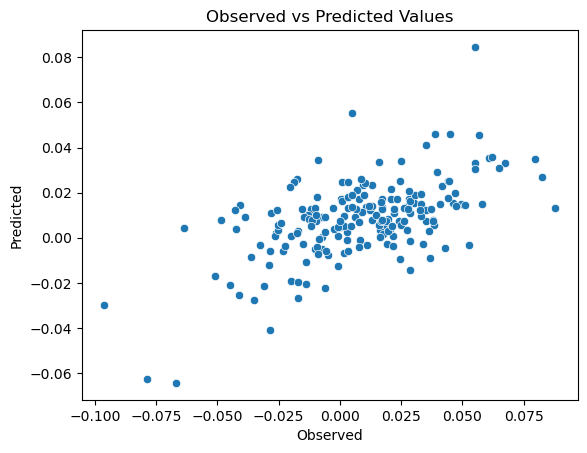

Mean of Residuals: -1.1031062103647388e-18


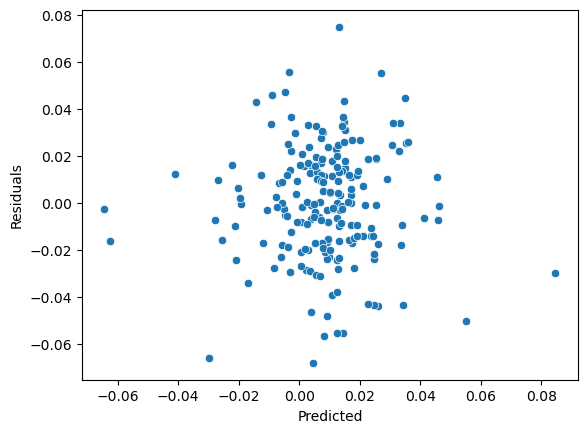

/Applications/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


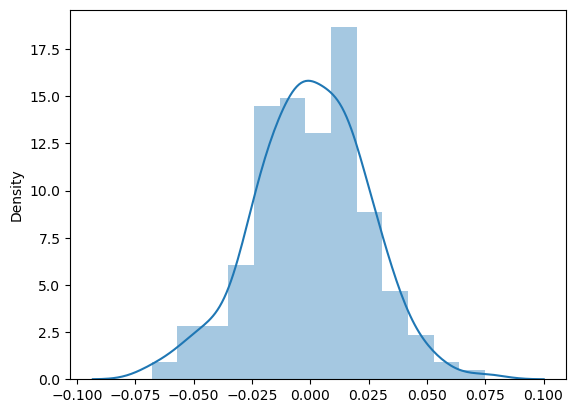

Shapiro-Wilk Test p-value: 0.6813001036643982
const : 1.0469058988878375
Factor - Value vs Growth : 2.1351117832699686
interaction_term2 : 1.5840005409090836
interaction_term3 : 1.6744090843894637
Factor - Interest Rates : 1.1608834572492226
Factor - Small Cap : 1.2740075323095026
Factor - Equity : 1.199572656063564
Factor - Momentum : 2.340594106640042


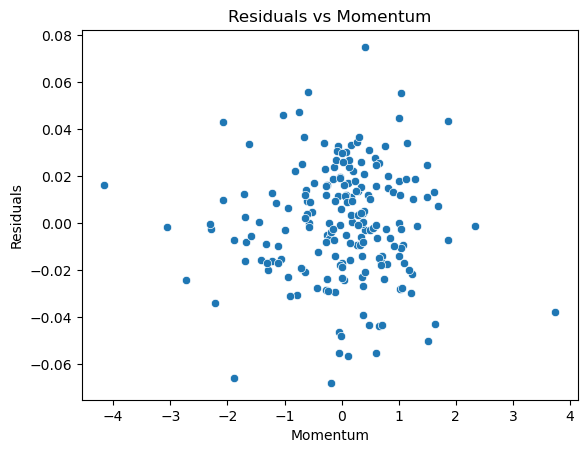

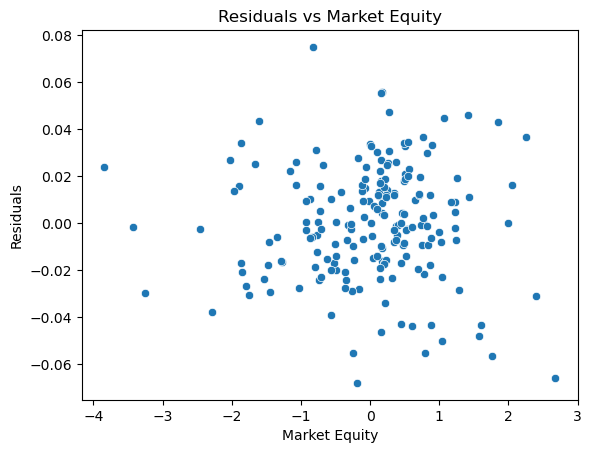

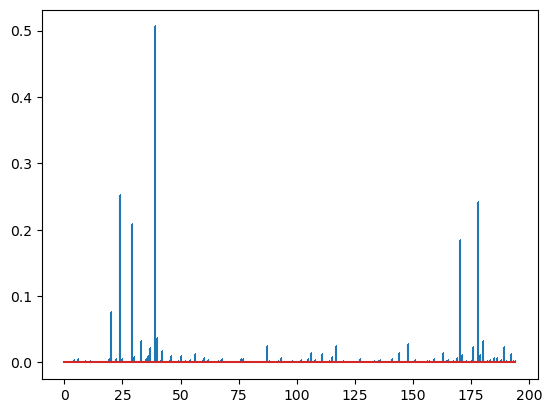

In [9]:
# Question 2.2 Evaluate Model

'''
10. To ensure the validity of the regression model, I conducted several diagnostic checks. These included examining the linearity between the observed and predicted values, verifying that the mean of the residuals is close to zero, assessing the homoscedasticity (equal variance of error terms), checking the normality of the residuals, and confirming the absence of multicollinearity using VIF.

11. I also plotted the residuals against different factors to identify any patterns or deviations that may need further investigation.

12. Finally, I used Cook's Distance to identify any outliers that may have a significant influence on the regression analysis.
'''

#Checking Assumptions:
# 1. Linearity
# Plotting the observed vs predicted values
sns.scatterplot(x=Y, y=model.predict())
plt.title('Observed vs Predicted Values')
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.show()

# 2. Mean of residuals
residuals = model.resid
print('Mean of Residuals:', np.mean(residuals))

# 3. Check for Homoscedasticity
sns.scatterplot(x=model.predict(), y=residuals)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.show()

# 4. Check for Normality of error terms/residuals
sns.distplot(residuals)
plt.show()

# Shapiro-Wilk test for normality
_, p_value = shapiro(residuals)
print('Shapiro-Wilk Test p-value:', p_value)

# 5. Check for Multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
for i, column in enumerate(X.columns):
    print(column, ":", vif[i])

# Checking patterns in the residuals plots
# Residuals vs Momentum
sns.scatterplot(x=df['Factor - Momentum'], y=model.resid)
plt.title('Residuals vs Momentum')
plt.xlabel('Momentum')
plt.ylabel('Residuals')
plt.show()

# Residuals vs Market Equity (possibly representing aggregate short interest)
sns.scatterplot(x=df['Factor - Equity'], y=model.resid)
plt.title('Residuals vs Market Equity')
plt.xlabel('Market Equity')
plt.ylabel('Residuals')
plt.show()

# Checking for outliers using Cook's Distance
influence = model.get_influence()
(c, p) = influence.cooks_distance
plt.stem(np.arange(len(c)), c, markerfmt=",")
plt.show()

In [10]:
# I also tried a log transformation to non-significant predictors but it made no difference. Code for log transformation is below.
'''
# Add a constant to shift negative values above zero in each column
df_transformed = df.copy()
non_significant_predictors = [ 
                              'Factor - Local Equity', 'Factor - Trend Following', 
                              'Factor - Commodities', 'Factor - Equity', 
                              'Factor - Foreign Exchange Carry', 'Factor - Small Cap', 
                              'Factor - Emerging Markets', 'Factor - Foreign Currency', 
                              'Factor - Equity Short Volatility', 
                              'Factor - Quality']

for column in non_significant_predictors:
    min_value = df_transformed[column].min()
    print(min_value)
    if min_value <= 0:
        constant = abs(min_value) + 0.01 # Add a small constant
        df_transformed[column] = df_transformed[column] + constant

for column in non_significant_predictors:
    min_value = df_transformed[column].min()
    print(min_value)
    
for column in non_significant_predictors:
    df_transformed[column] = np.log(df_transformed[column])

print(df_transformed.head(5))

# Checking for any missing data
print(df_transformed.isna().sum())
'''

"\n# Add a constant to shift negative values above zero in each column\ndf_transformed = df.copy()\nnon_significant_predictors = [ \n                              'Factor - Local Equity', 'Factor - Trend Following', \n                              'Factor - Commodities', 'Factor - Equity', \n                              'Factor - Foreign Exchange Carry', 'Factor - Small Cap', \n                              'Factor - Emerging Markets', 'Factor - Foreign Currency', \n                              'Factor - Equity Short Volatility', \n                              'Factor - Quality']\n\nfor column in non_significant_predictors:\n    min_value = df_transformed[column].min()\n    print(min_value)\n    if min_value <= 0:\n        constant = abs(min_value) + 0.01 # Add a small constant\n        df_transformed[column] = df_transformed[column] + constant\n\nfor column in non_significant_predictors:\n    min_value = df_transformed[column].min()\n    print(min_value)\n    \nfor column in non_si

# 2.3 & 2.4 Investing in the fund vs investing in the factor portfolio

Here I determine which strategy would be more profitable and calculate the Sharpe ratios for each.

However when assessing the profitability of investing directly in the underlying factors versus the fund, these interaction terms complicate things since they suggest that the relationship between the fund returns and these factor pairs depends on the values of both factors.

Specifically, the fund seems to be leveraging the interplay between 'Factor - Small Cap' and 'Factor - Momentum' as well as 'Factor - Equity' and 'Factor - Momentum' to generate returns. Simply investing in these individual factors might not yield the same results, as it may not capture the same interaction effects.

Therefore, important to note that replicating the exact returns of the fund by investing in these factors directly could be difficult due to these interaction effects. The Sharpe ratio calculated for each individual factor and for the interaction terms will provide a sense of the risk-adjusted return for each. However, it won't fully capture the complexity of the interaction effects, so it may overstate the potential returns of investing directly in the underlying factors.

In conclusion, considering the interaction terms, it might not be as simple as investing in the individual factors and expecting the same return as the fund. It could be more profitable to invest in the fund, despite any performance and management fees, because the fund manager is presumably skilled at leveraging these interaction effects to generate returns.

Note: To calculate the Sharpe ratio, I assume the risk-free rate (denoted rf in my code) is 0.

In [11]:
# Calculate expected returns
expected_return_fund = np.mean(df['Hedge Fund'])
expected_return_factors = np.mean(df[['Factor - Value vs Growth', 
                                      'Factor - Interest Rates', 
                                      'Factor - Small Cap', 
                                      'Factor - Equity', 
                                      'Factor - Momentum',
                                      'interaction_term2', 
                                      'interaction_term3']], axis=0)

# Calculate standard deviations
std_dev_fund = np.std(df['Hedge Fund'])
std_dev_factors = np.std(df[['Factor - Value vs Growth', 
                             'Factor - Interest Rates', 
                             'Factor - Small Cap', 
                             'Factor - Equity', 
                             'Factor - Momentum',
                             'interaction_term2', 
                             'interaction_term3']], axis=0)

# Calculate Sharpe ratios
sharpe_ratio_fund = expected_return_fund / std_dev_fund
sharpe_ratio_factors = expected_return_factors / std_dev_factors

print("Sharpe ratio for the fund:", sharpe_ratio_fund)
print("\nSharpe ratios for the factors and interaction terms:")
print(sharpe_ratio_factors)
print("Standard deviation for the fund:", std_dev_fund)
print("Standard deviation for the factors:", std_dev_factors)

Sharpe ratio for the fund: 0.28516881307524167

Sharpe ratios for the factors and interaction terms:
Factor - Value vs Growth    2.562053e-17
Factor - Interest Rates    -2.149278e-17
Factor - Small Cap          2.220446e-17
Factor - Equity            -1.480297e-17
Factor - Momentum          -9.678867e-18
interaction_term2          -1.997768e-01
interaction_term3          -6.784607e-02
dtype: float64
Standard deviation for the fund: 0.029546658329467138
Standard deviation for the factors: Factor - Value vs Growth    1.000000
Factor - Interest Rates     1.000000
Factor - Small Cap          1.000000
Factor - Equity             1.000000
Factor - Momentum           1.000000
interaction_term2           1.442361
interaction_term3           1.464099
dtype: float64


**Comparison of the Sharpe ratios and risk measures for the fund, individual factors, and interaction terms:**

1. Fund: The fund has a Sharpe ratio of 0.285, indicating that it provides positive excess return for its level of risk. Although this ratio is considered relatively low, it's important to consider it within the context of the market conditions and comparable investments. Comparatively, the Sharpe ratios for the individual factors are close to zero, suggesting that these factors alone do not provide significant excess returns.

2. Interaction terms: Interestingly, the interaction terms have negative Sharpe ratios, indicating that the combined factors result in negative excess returns for their level of risk. This suggests that strategies based on these interaction terms would actually result in a loss of value.

Considering these results, it seems that the fund, despite having a relatively low Sharpe ratio, is likely to be the most profitable strategy compared to investing directly in the factors or the interaction terms. It's possible that the fund manager effectively manages the interactions between factors to generate positive returns, explaining the higher Sharpe ratio for the fund.

**2.4: analysis of risk**

The standard deviation for the fund is significantly lower than the standard deviations for the individual factors and the interaction terms. This indicates that the returns from the fund are less volatile and hence less risky compared to the factors and interaction terms.

For the individual factors, the standard deviation is exactly 1 for each, which suggests that these factor returns have been normalized to have a mean of 0 and a standard deviation of 1 for comparability.

On the other hand, the interaction terms have higher standard deviations, implying that the returns from these terms are more volatile and riskier than the returns from the individual factors.

In conclusion, considering both the Sharpe ratio and standard deviation, investing in the fund appears to be a less risky strategy compared to investing directly in the factors or the interaction terms. However, I note that lower risk often corresponds to lower potential returns so the final decision will depend on the potential returns, risk tolerance, and individual investment preferences. 

# 2.5 Are the betas you calculated stationary?

To test the stationarity of the betas, I use the Augmented Dickey-Fuller test. The null hypothesis of the ADF test is that the time series is not stationary (it has some time-dependent structure), while the alternative hypothesis is that the time series is stationary.

In [12]:
from statsmodels.tsa.stattools import adfuller
# Define the list of features used in the final model
features = ['Factor - Value vs Growth', 'interaction_term2', 'interaction_term3', 
                  'Factor - Interest Rates', 'Factor - Small Cap', 'Factor - Equity', 
                  'Factor - Momentum']

for feature in features:
    result = adfuller(df[feature])
    print(f'ADF Statistic for {feature}: {result[0]}')
    print(f'p-value: {result[1]}')

ADF Statistic for Factor - Value vs Growth: -12.049083069650795
p-value: 2.6229110345163866e-22
ADF Statistic for interaction_term2: -11.259675984091416
p-value: 1.6338239309364167e-20
ADF Statistic for interaction_term3: -7.264714075937468
p-value: 1.646475167040029e-10
ADF Statistic for Factor - Interest Rates: -10.636943807754612
p-value: 5.043845740885752e-19
ADF Statistic for Factor - Small Cap: -13.31839627405495
p-value: 6.532735136485753e-25
ADF Statistic for Factor - Equity: -12.236351393816797
p-value: 1.0260427137433216e-22
ADF Statistic for Factor - Momentum: -12.814118343257217
p-value: 6.353981411507834e-24


For all the factors and interaction terms, the p-value is very close to zero, which means we can reject the null hypothesis that a unit root is present in the time series. This suggests that all of these time series are stationary, or in other words, their properties do not depend on the time at which they are observed.